# Datathon Cajamar UniversityHack 2022 - Cajamar Water Footprint

## Script Predicción - Equipo DPNA

## Imports y leer csv

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

pd.options.display.max_info_rows = 30000000

sns.set_style('darkgrid')

# Tamaño figuras
plt.rcParams["figure.figsize"] = (15,6)

In [2]:
df = pd.read_csv('data/Modelar_Procesado_4.csv', index_col='ID', parse_dates=True)
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])
df.head()

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL
ID,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,0.0,0,0.0,2019,2,1,0,5,0,0,0
0,2019-02-01 01:00:00,331710.0,0.0,0,0.0,2019,2,1,1,5,0,0,0
0,2019-02-01 02:00:00,331710.0,0.0,0,0.0,2019,2,1,2,5,0,0,0
0,2019-02-01 03:00:00,331710.0,0.0,0,0.0,2019,2,1,3,5,0,0,0
0,2019-02-01 04:00:00,331710.0,0.0,0,0.0,2019,2,1,4,5,0,0,0


## Unir DataFrame con el de Precipitaciones, Temperatura y Humedad

In [3]:
df2 = pd.read_csv('data/PrecHumTempValencia.csv', sep='\;', encoding='ISO-8859-1')
df2.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,"""Fecha Hora",Estación,Temp,H.Rel,R.Sol,"Precip"""
0,"""01/01/2020 0:00",Avda. Francia,"6,6",890.0,0.0,"0"""
1,"""01/01/2020 1:00",Avda. Francia,"6,2",890.0,0.0,"0"""
2,"""01/01/2020 2:00",Avda. Francia,"5,9",900.0,0.0,"0"""
3,"""01/01/2020 3:00",Avda. Francia,"5,5",900.0,0.0,"0"""
4,"""01/01/2020 4:00",Avda. Francia,"5,3",890.0,0.0,"0"""


In [4]:
df2 = df2.replace('"','', regex=True)
df2 = df2.replace(',','.', regex=True)
df2 = df2.rename(columns={"\"Fecha Hora": "Fecha", "Precip\"": "Precip"})
df2["Temp"] = pd.to_numeric(df2["Temp"])
df2["H.Rel"] = pd.to_numeric(df2["H.Rel"])
df2["R.Sol"] = pd.to_numeric(df2["R.Sol"])
df2["Precip"] = pd.to_numeric(df2["Precip"])
df2['Fecha'] = pd.to_datetime(df2.Fecha)
df2 = df2.set_index("Fecha")
df2

,Estación,Temp,H.Rel,R.Sol,Precip
Fecha,,,,,
2020-01-01 00:00:00,Avda. Francia,6.6,890.0,0.0,0.0
2020-01-01 01:00:00,Avda. Francia,6.2,890.0,0.0,0.0
2020-01-01 02:00:00,Avda. Francia,5.9,900.0,0.0,0.0
2020-01-01 03:00:00,Avda. Francia,5.5,900.0,0.0,0.0
2020-01-01 04:00:00,Avda. Francia,5.3,890.0,0.0,0.0
...,...,...,...,...,...
2018-12-23 01:00:00,Politécnico,11.5,760.0,20.0,0.0
2018-12-23 02:00:00,Politécnico,11.0,770.0,10.0,0.0
2018-12-23 03:00:00,Politécnico,10.9,770.0,10.0,0.0


In [5]:
df2 = df2.sort_index()
df_group = df2.groupby("Fecha").mean()
df_group

,Temp,H.Rel,R.Sol,Precip
Fecha,,,,
2018-01-01 00:00:00,14.20,380.0,0.0,0.0
2018-01-01 01:00:00,12.80,460.0,0.0,0.0
2018-01-01 02:00:00,12.10,460.0,0.0,0.0
2018-01-01 03:00:00,11.20,450.0,0.0,0.0
2018-01-01 04:00:00,10.60,460.0,0.0,0.0
...,...,...,...,...
2020-12-31 19:00:00,11.15,442.0,4.0,0.0
2020-12-31 20:00:00,10.51,474.0,14.0,0.0
2020-12-31 21:00:00,10.37,506.0,4.0,0.0


In [6]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2018-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    25882 non-null  float64
 1   H.Rel   25170 non-null  float64
 2   R.Sol   25850 non-null  float64
 3   Precip  25858 non-null  float64
dtypes: float64(4)
memory usage: 1.0 MB


In [7]:
pd.date_range(start=pd.Timestamp('2018-01-01T00'), end=pd.Timestamp('2020-12-31T23'), freq='60T')

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='60T')

In [8]:
imp = SimpleImputer(missing_values=np.nan)
idf = pd.DataFrame(imp.fit_transform(df_group))
idf.columns = df_group.columns
idf.index = df_group.index
idf

,Temp,H.Rel,R.Sol,Precip
Fecha,,,,
2018-01-01 00:00:00,14.20,380.0,0.0,0.0
2018-01-01 01:00:00,12.80,460.0,0.0,0.0
2018-01-01 02:00:00,12.10,460.0,0.0,0.0
2018-01-01 03:00:00,11.20,450.0,0.0,0.0
2018-01-01 04:00:00,10.60,460.0,0.0,0.0
...,...,...,...,...
2020-12-31 19:00:00,11.15,442.0,4.0,0.0
2020-12-31 20:00:00,10.51,474.0,14.0,0.0
2020-12-31 21:00:00,10.37,506.0,4.0,0.0


In [9]:
dfjoin = df.set_index('SAMPLETIME', append=True).reset_index(level=0)
dfjoin = dfjoin.join(idf)
dfjoin = dfjoin.set_index('ID', append=True).reset_index(level=0)
dfjoin = dfjoin.rename(columns={"level_0": "SAMPLETIME"})
dfjoin

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip
ID,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,0.0,0,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0
1,2019-02-01 00:00:00,5825.0,0.0,0,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0
2,2019-02-01 00:00:00,7951.0,0.0,0,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0
3,2019-02-01 00:00:00,150316.0,0.0,37,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0
4,2019-02-01 00:00:00,113385.0,0.0,14,56.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-01-31 23:00:00,11813.0,0.0,0,0.0,2020,1,31,23,5,0,0,0,14.89,617.0,0.0,0.0
2735,2020-01-31 23:00:00,63785.0,0.0,0,0.0,2020,1,31,23,5,0,0,0,14.89,617.0,0.0,0.0
2736,2020-01-31 23:00:00,32783.0,0.0,36,0.0,2020,1,31,23,5,0,0,0,14.89,617.0,0.0,0.0


## Unir DataFrame con el de Precios

In [10]:
dfjoin['FECHA'] = dfjoin['SAMPLETIME'].dt.strftime('%F')
dfjoin['FECHA'] = pd.to_datetime(dfjoin.FECHA)
dfjoin

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,FECHA
ID,,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,0.0,0,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0,2019-02-01
1,2019-02-01 00:00:00,5825.0,0.0,0,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0,2019-02-01
2,2019-02-01 00:00:00,7951.0,0.0,0,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0,2019-02-01
3,2019-02-01 00:00:00,150316.0,0.0,37,0.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0,2019-02-01
4,2019-02-01 00:00:00,113385.0,0.0,14,56.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0,2019-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-01-31 23:00:00,11813.0,0.0,0,0.0,2020,1,31,23,5,0,0,0,14.89,617.0,0.0,0.0,2020-01-31
2735,2020-01-31 23:00:00,63785.0,0.0,0,0.0,2020,1,31,23,5,0,0,0,14.89,617.0,0.0,0.0,2020-01-31
2736,2020-01-31 23:00:00,32783.0,0.0,36,0.0,2020,1,31,23,5,0,0,0,14.89,617.0,0.0,0.0,2020-01-31


In [11]:
precios_df = pd.read_excel('data\DATOS DIAS.xlsx')
precios_df = precios_df.astype({'FECHA': 'datetime64[ns]'})
precios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   FECHA                        425 non-null    datetime64[ns]
 1   TARIFA DIARIA COMPLETA       425 non-null    object        
 2   OCUPACIÓN DIARIA COMPLETA    425 non-null    float64       
 3   TARIFA DIARIA COMPARTIDA     425 non-null    float64       
 4   OCUPACIÓN DIARIA COMPARTIDA  425 non-null    float64       
 5   TARIFA DIARIA PRIVADA        425 non-null    float64       
 6   OCUPACIÓN DIARIA PRIVADA     425 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 23.4+ KB


In [12]:
precios_df = precios_df.set_index('FECHA')
df3 = dfjoin.set_index('FECHA', append=True).reset_index(level=0)
df3 = df3.join(precios_df)
df3 = df3.set_index('ID', append=True).reset_index(level=0)
dfjoin = df3.rename(columns={"level_0": "FECHA"})
dfjoin

,FECHA,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,HOUR,...,Temp,H.Rel,R.Sol,Precip,TARIFA DIARIA COMPLETA,OCUPACIÓN DIARIA COMPLETA,TARIFA DIARIA COMPARTIDA,OCUPACIÓN DIARIA COMPARTIDA,TARIFA DIARIA PRIVADA,OCUPACIÓN DIARIA PRIVADA
ID,,,,,,,,,,,,,,,,,,,,,
0,2019-02-01,2019-02-01 00:00:00,331710.0,0.0,0,0.0,2019,2,1,0,...,9.10,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
1,2019-02-01,2019-02-01 00:00:00,5825.0,0.0,0,0.0,2019,2,1,0,...,9.10,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
2,2019-02-01,2019-02-01 00:00:00,7951.0,0.0,0,0.0,2019,2,1,0,...,9.10,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
3,2019-02-01,2019-02-01 00:00:00,150316.0,0.0,37,0.0,2019,2,1,0,...,9.10,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
4,2019-02-01,2019-02-01 00:00:00,113385.0,0.0,14,56.0,2019,2,1,0,...,9.10,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-01-31,2020-01-31 23:00:00,11813.0,0.0,0,0.0,2020,1,31,23,...,14.89,617.0,0.0,0.0,71.25,0.536,44.00,0.165,29.45,0.351
2735,2020-01-31,2020-01-31 23:00:00,63785.0,0.0,0,0.0,2020,1,31,23,...,14.89,617.0,0.0,0.0,71.25,0.536,44.00,0.165,29.45,0.351
2736,2020-01-31,2020-01-31 23:00:00,32783.0,0.0,36,0.0,2020,1,31,23,...,14.89,617.0,0.0,0.0,71.25,0.536,44.00,0.165,29.45,0.351


## Unir DataFrame con el de Hoteles

In [13]:
hoteles_df = pd.read_excel('data\VIAJEROS Y PERNOTACIONES DE HOTELES Y APARTAMENTOS.xlsx')
hoteles_df = hoteles_df.drop(hoteles_df.columns[[0,1,2,3,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25]], axis=1)
precios_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2019-01-01 to 2020-02-29
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARIFA DIARIA COMPLETA       425 non-null    object 
 1   OCUPACIÓN DIARIA COMPLETA    425 non-null    float64
 2   TARIFA DIARIA COMPARTIDA     425 non-null    float64
 3   OCUPACIÓN DIARIA COMPARTIDA  425 non-null    float64
 4   TARIFA DIARIA PRIVADA        425 non-null    float64
 5   OCUPACIÓN DIARIA PRIVADA     425 non-null    float64
dtypes: float64(5), object(1)
memory usage: 39.4+ KB


In [14]:
dfjoin['FECHA2'] = dfjoin['SAMPLETIME'].dt.strftime('%Y-%m')
dfjoin['FECHA2'] = pd.to_datetime(dfjoin.FECHA2)
dfjoin

,FECHA,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,HOUR,...,H.Rel,R.Sol,Precip,TARIFA DIARIA COMPLETA,OCUPACIÓN DIARIA COMPLETA,TARIFA DIARIA COMPARTIDA,OCUPACIÓN DIARIA COMPARTIDA,TARIFA DIARIA PRIVADA,OCUPACIÓN DIARIA PRIVADA,FECHA2
ID,,,,,,,,,,,,,,,,,,,,,
0,2019-02-01,2019-02-01 00:00:00,331710.0,0.0,0,0.0,2019,2,1,0,...,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378,2019-02-01
1,2019-02-01,2019-02-01 00:00:00,5825.0,0.0,0,0.0,2019,2,1,0,...,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378,2019-02-01
2,2019-02-01,2019-02-01 00:00:00,7951.0,0.0,0,0.0,2019,2,1,0,...,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378,2019-02-01
3,2019-02-01,2019-02-01 00:00:00,150316.0,0.0,37,0.0,2019,2,1,0,...,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378,2019-02-01
4,2019-02-01,2019-02-01 00:00:00,113385.0,0.0,14,56.0,2019,2,1,0,...,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378,2019-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-01-31,2020-01-31 23:00:00,11813.0,0.0,0,0.0,2020,1,31,23,...,617.0,0.0,0.0,71.25,0.536,44.00,0.165,29.45,0.351,2020-01-01
2735,2020-01-31,2020-01-31 23:00:00,63785.0,0.0,0,0.0,2020,1,31,23,...,617.0,0.0,0.0,71.25,0.536,44.00,0.165,29.45,0.351,2020-01-01
2736,2020-01-31,2020-01-31 23:00:00,32783.0,0.0,36,0.0,2020,1,31,23,...,617.0,0.0,0.0,71.25,0.536,44.00,0.165,29.45,0.351,2020-01-01


In [15]:
hoteles_df['AÑO'] = hoteles_df['AÑO'].astype(str)
hoteles_df['MES'] = hoteles_df['MES'].astype(str)
hoteles_df['FECHA2'] = hoteles_df['AÑO'] + "-" + hoteles_df['MES']
hoteles_df['FECHA2'] = pd.to_datetime(hoteles_df.FECHA2)
hoteles_df = hoteles_df.set_index('FECHA2')
hoteles_df

,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
FECHA2,,,,
2019-01-01,303245,40.955,1,2019
2019-02-01,311599,46.870,2,2019
2019-03-01,419853,53.790,3,2019
2019-04-01,477711,64.705,4,2019
2019-05-01,490101,65.195,5,2019
2019-06-01,496639,67.390,6,2019
2019-07-01,555251,72.695,7,2019
2019-08-01,610223,74.975,8,2019
2019-09-01,482365,69.155,9,2019


In [16]:
df3 = dfjoin.set_index('FECHA2', append=True).reset_index(level=0)
df3 = df3.join(hoteles_df)
df3 = df3.set_index('ID', append=True).reset_index(level=0)
dfjoin = df3.rename(columns={"level_0": "FECHA2"})
dfjoin

,FECHA2,FECHA,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,YEAR,MONTH,DAY,...,TARIFA DIARIA COMPLETA,OCUPACIÓN DIARIA COMPLETA,TARIFA DIARIA COMPARTIDA,OCUPACIÓN DIARIA COMPARTIDA,TARIFA DIARIA PRIVADA,OCUPACIÓN DIARIA PRIVADA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
ID,,,,,,,,,,,,,,,,,,,,,
0,2019-02-01,2019-02-01,2019-02-01 00:00:00,331710.0,0.0,0,0.0,2019,2,1,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
1,2019-02-01,2019-02-01,2019-02-01 00:00:00,5825.0,0.0,0,0.0,2019,2,1,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
2,2019-02-01,2019-02-01,2019-02-01 00:00:00,7951.0,0.0,0,0.0,2019,2,1,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
3,2019-02-01,2019-02-01,2019-02-01 00:00:00,150316.0,0.0,37,0.0,2019,2,1,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
4,2019-02-01,2019-02-01,2019-02-01 00:00:00,113385.0,0.0,14,56.0,2019,2,1,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2734,2020-01-01,2020-01-31,2020-01-31 23:00:00,11813.0,0.0,0,0.0,2020,1,31,...,71.25,0.536,44.00,0.165,29.45,0.351,339021,43.13,1,2020
2735,2020-01-01,2020-01-31,2020-01-31 23:00:00,63785.0,0.0,0,0.0,2020,1,31,...,71.25,0.536,44.00,0.165,29.45,0.351,339021,43.13,1,2020
2736,2020-01-01,2020-01-31,2020-01-31 23:00:00,32783.0,0.0,36,0.0,2020,1,31,...,71.25,0.536,44.00,0.165,29.45,0.351,339021,43.13,1,2020


Borramos variables que no queremos

In [ ]:
dfjoin = dfjoin.drop(["FECHA2", "FECHA", "MES", "AÑO"], axis=1)

Guardamos dataset "final"

In [17]:
dfjoin.to_csv('data/Modelar_Procesado_DEF.csv')

## Modificaciones en el dataset

Primero vamos a borrar las columnas READINGTHOUSANDTH, DELTAINTEGER Y DELTATHOUSANDTH, ya que vamos a predecir los valores perdidos. Además, también borramos los MINUTE y SECONDS

In [33]:
df = pd.read_csv('data/Modelar_Procesado_DEF.csv')
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])
df = df.set_index('ID')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
df = df.drop(['FECHA2', 'FECHA', 'READINGTHOUSANDTH', 'DELTAINTEGER', 'DELTATHOUSANDTH'], axis=1)
df

,SAMPLETIME,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,...,TARIFA DIARIA COMPLETA,OCUPACIÓN DIARIA COMPLETA,TARIFA DIARIA COMPARTIDA,OCUPACIÓN DIARIA COMPARTIDA,TARIFA DIARIA PRIVADA,OCUPACIÓN DIARIA PRIVADA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
ID,,,,,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,2019,2,1,0,5,0,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.870,2,2019
0,2019-02-01 01:00:00,331710.0,2019,2,1,1,5,0,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.870,2,2019
0,2019-02-01 02:00:00,331710.0,2019,2,1,2,5,0,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.870,2,2019
0,2019-02-01 03:00:00,331710.0,2019,2,1,3,5,0,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.870,2,2019
0,2019-02-01 04:00:00,331710.0,2019,2,1,4,5,0,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.870,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,2019-10-11 07:00:00,164507.0,2019,10,11,7,5,0,0,0,...,80.48,0.705,39.50,0.206,31.86,0.494,472435,64.245,10,2019
2756,2019-04-06 04:00:00,349758.0,2019,4,6,4,6,0,0,0,...,76.75,0.686,24.92,0.218,28.66,0.444,477711,64.705,4,2019
2756,2019-04-06 05:00:00,349758.0,2019,4,6,5,6,0,0,0,...,76.75,0.686,24.92,0.218,28.66,0.444,477711,64.705,4,2019


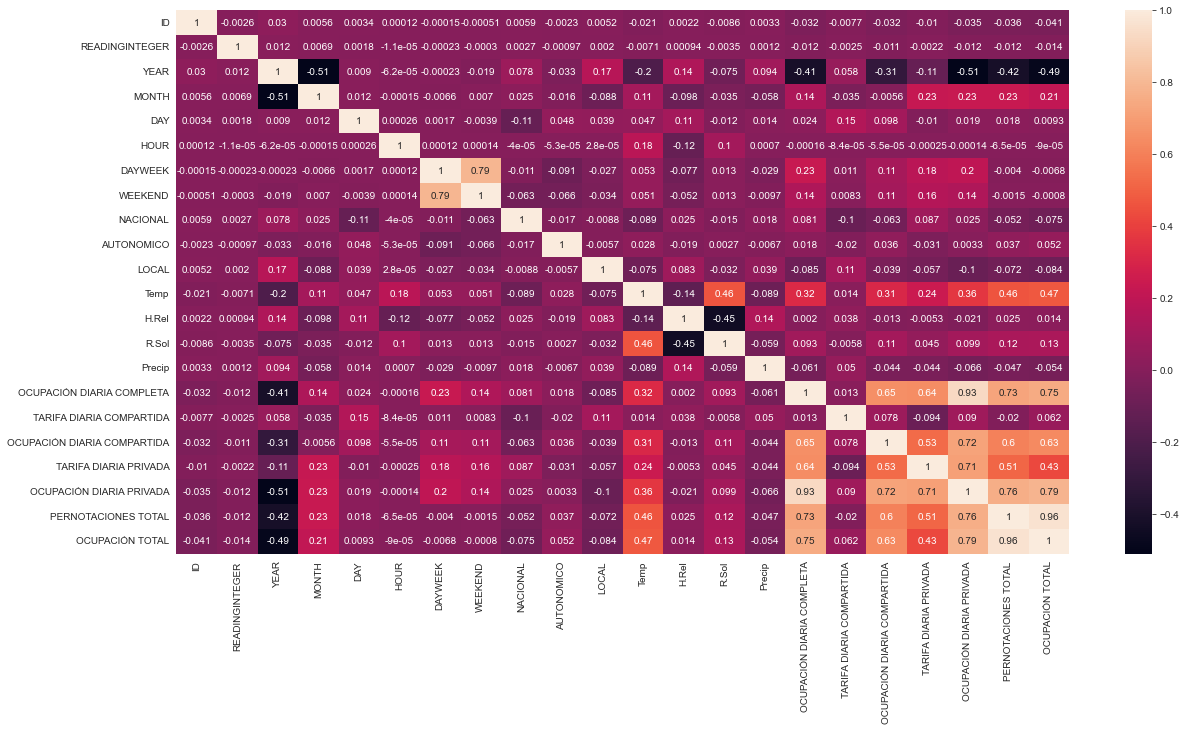

In [17]:
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.show()

In [35]:
df = df.drop(['TARIFA DIARIA COMPLETA', 'TARIFA DIARIA COMPARTIDA', 'OCUPACIÓN DIARIA COMPARTIDA', 'TARIFA DIARIA PRIVADA', 'OCUPACIÓN DIARIA PRIVADA'], axis=1)
df

,SAMPLETIME,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
ID,,,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,0.561,311599,46.870,2,2019
0,2019-02-01 01:00:00,331710.0,2019,2,1,1,5,0,0,0,8.9,670.0,0.0,0.0,0.561,311599,46.870,2,2019
0,2019-02-01 02:00:00,331710.0,2019,2,1,2,5,0,0,0,8.8,640.0,0.0,0.0,0.561,311599,46.870,2,2019
0,2019-02-01 03:00:00,331710.0,2019,2,1,3,5,0,0,0,8.3,660.0,0.0,0.0,0.561,311599,46.870,2,2019
0,2019-02-01 04:00:00,331710.0,2019,2,1,4,5,0,0,0,9.7,550.0,0.0,0.0,0.561,311599,46.870,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,2019-10-11 07:00:00,164507.0,2019,10,11,7,5,0,0,0,10.5,470.0,480.0,0.0,0.705,472435,64.245,10,2019
2756,2019-04-06 04:00:00,349758.0,2019,4,6,4,6,0,0,0,18.3,770.0,0.0,0.0,0.686,477711,64.705,4,2019
2756,2019-04-06 05:00:00,349758.0,2019,4,6,5,6,0,0,0,18.0,770.0,80.0,0.0,0.686,477711,64.705,4,2019


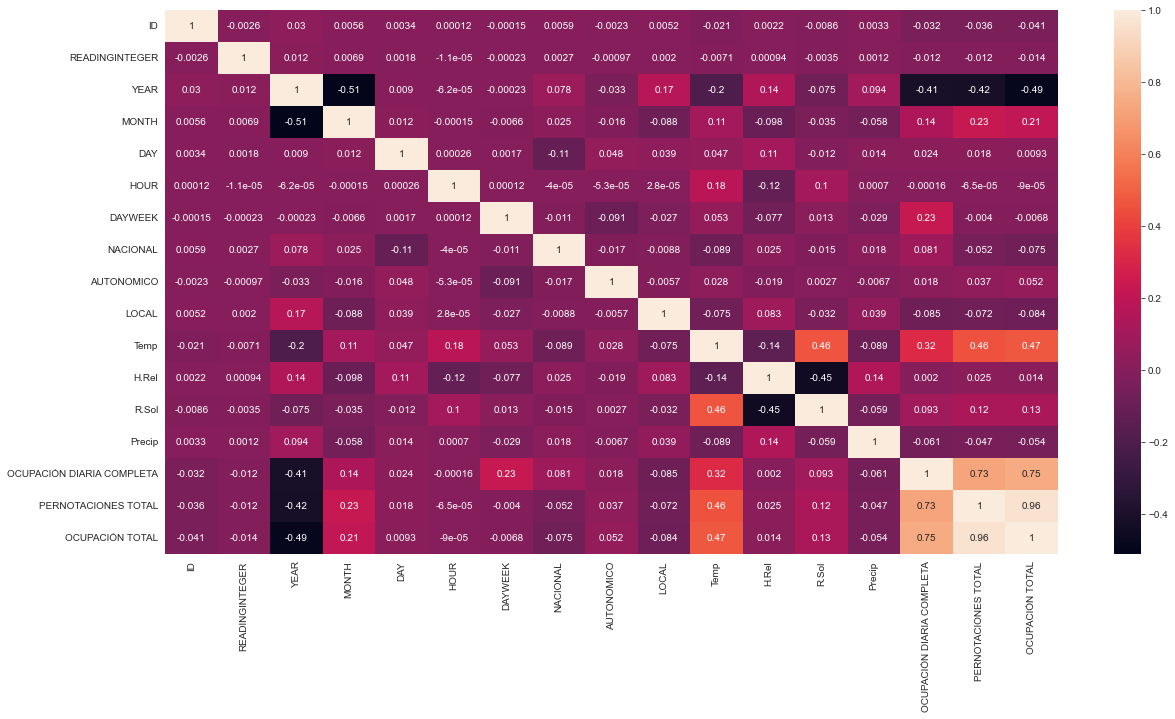

In [19]:
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.show()

### Valores perdidos con XGBoost (abajo)

### Rellenar valores perdidos con imputador de Pandas

Hemos probado que XGBoost lo hace horriblemente mal, así que vamos a probar otra forma

In [36]:
time_values = df.loc[0]["SAMPLETIME"].values
time_values

array(['2019-02-01T00:00:00.000000000', '2019-02-01T01:00:00.000000000',
       '2019-02-01T02:00:00.000000000', ...,
       '2020-01-31T21:00:00.000000000', '2020-01-31T22:00:00.000000000',
       '2020-01-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
valores_base = df.loc[0].set_index('SAMPLETIME')
valores_base

,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
SAMPLETIME,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,331710.0,2019,2,1,0,5,0,0,0,9.10,700.0,0.0,0.0,0.561,311599,46.87,2,2019
2019-02-01 01:00:00,331710.0,2019,2,1,1,5,0,0,0,8.90,670.0,0.0,0.0,0.561,311599,46.87,2,2019
2019-02-01 02:00:00,331710.0,2019,2,1,2,5,0,0,0,8.80,640.0,0.0,0.0,0.561,311599,46.87,2,2019
2019-02-01 03:00:00,331710.0,2019,2,1,3,5,0,0,0,8.30,660.0,0.0,0.0,0.561,311599,46.87,2,2019
2019-02-01 04:00:00,331710.0,2019,2,1,4,5,0,0,0,9.70,550.0,0.0,0.0,0.561,311599,46.87,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 19:00:00,434941.0,2020,1,31,19,5,0,0,0,16.77,591.0,0.0,0.0,0.536,339021,43.13,1,2020
2020-01-31 20:00:00,434951.0,2020,1,31,20,5,0,0,0,16.13,594.0,0.0,0.0,0.536,339021,43.13,1,2020
2020-01-31 21:00:00,434952.0,2020,1,31,21,5,0,0,0,15.57,612.0,0.0,0.0,0.536,339021,43.13,1,2020


In [38]:
dic = {'ID': [], 'SAMPLETIME': [], 'READINGINTEGER': [], 'YEAR': [], 'MONTH': [], 'DAY': [], 
       'HOUR': [], 'DAYWEEK': [], 'NACIONAL': [], 'AUTONOMICO': [], 'LOCAL': [], 
       'Temp': [], 'H.Rel': [], 'R.Sol': [], 'Precip': [], 
       'OCUPACIÓN DIARIA COMPLETA': [], 'PERNOTACIONES TOTAL': [], 'OCUPACIÓN TOTAL': []}
list_i = []
						
# Para cada índice
for i in tqdm(df.index.drop_duplicates()):
    df_temp = df.loc[i]
    
    # Si le faltan valores
    if df_temp.size != df.loc[0].size:
        time_values_temp = df_temp["SAMPLETIME"].values
        list_i.append(i)
        
        # Para cada valor posible de fecha/hora
        for time in time_values:
            
            # Si no existe para el ID actual, lo añadimos
            if time not in time_values_temp:
                fila = valores_base.loc[time]
                dic['ID'].append(i)
                dic['SAMPLETIME'].append(time)
                dic['READINGINTEGER'].append(np.nan)
                dic['YEAR'].append(fila['YEAR'])
                dic['MONTH'].append(fila['MONTH'])
                dic['DAY'].append(fila['DAY'])
                dic['HOUR'].append(fila['HOUR'])
                dic['DAYWEEK'].append(fila['DAYWEEK'])
                dic['NACIONAL'].append(fila['NACIONAL'])
                dic['AUTONOMICO'].append(fila['AUTONOMICO'])
                dic['LOCAL'].append(fila['LOCAL'])
                dic['Temp'].append(fila['Temp'])
                dic['H.Rel'].append(fila['H.Rel'])
                dic['R.Sol'].append(fila['R.Sol'])
                dic['Precip'].append(fila['Precip'])
                dic['OCUPACIÓN DIARIA COMPLETA'].append(fila['OCUPACIÓN DIARIA COMPLETA'])
                dic['PERNOTACIONES TOTAL'].append(fila['PERNOTACIONES TOTAL'])
                dic['OCUPACIÓN TOTAL'].append(fila['OCUPACIÓN TOTAL'])

100%|██████████| 2747/2747 [07:36<00:00,  6.02it/s]


In [39]:
df_dictionary = pd.DataFrame(dic)
df_dictionary = df_dictionary.set_index('ID')
df = pd.concat([df, df_dictionary], ignore_index=False)
df = df.sort_values(["ID", 'SAMPLETIME'])

In [40]:
df

,SAMPLETIME,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
ID,,,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,9.10,700.0,0.0,0.0,0.561,311599.0,46.87,2.0,2019.0
0,2019-02-01 01:00:00,331710.0,2019.0,2.0,1.0,1.0,5.0,0.0,0.0,0.0,8.90,670.0,0.0,0.0,0.561,311599.0,46.87,2.0,2019.0
0,2019-02-01 02:00:00,331710.0,2019.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,8.80,640.0,0.0,0.0,0.561,311599.0,46.87,2.0,2019.0
0,2019-02-01 03:00:00,331710.0,2019.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,8.30,660.0,0.0,0.0,0.561,311599.0,46.87,2.0,2019.0
0,2019-02-01 04:00:00,331710.0,2019.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,9.70,550.0,0.0,0.0,0.561,311599.0,46.87,2.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,2020-01-31 19:00:00,NaN,2020.0,1.0,31.0,19.0,5.0,0.0,0.0,0.0,16.77,591.0,0.0,0.0,0.536,339021.0,43.13,NaN,NaN
2756,2020-01-31 20:00:00,NaN,2020.0,1.0,31.0,20.0,5.0,0.0,0.0,0.0,16.13,594.0,0.0,0.0,0.536,339021.0,43.13,NaN,NaN
2756,2020-01-31 21:00:00,NaN,2020.0,1.0,31.0,21.0,5.0,0.0,0.0,0.0,15.57,612.0,0.0,0.0,0.536,339021.0,43.13,NaN,NaN


In [48]:
df = df.drop(['MES','AÑO'],axis=1)

In [41]:
df.to_csv('data/Modelar_Procesado_conNaN.csv')

#### Y una vez hecho esto, vamos a imputar los NaN

In [42]:
df = pd.read_csv('data/Modelar_Procesado_conNaN.csv', index_col='ID')
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Primero vamos a escalar los nuevos valores

In [43]:
scaler = MinMaxScaler()
df[['Temp', 'H.Rel', 'R.Sol', 'Precip', 'OCUPACIÓN DIARIA COMPLETA', 'PERNOTACIONES TOTAL', 'OCUPACIÓN TOTAL']] = scaler.fit_transform(df[['Temp', 'H.Rel', 'R.Sol', 'Precip', 'OCUPACIÓN DIARIA COMPLETA', 'PERNOTACIONES TOTAL', 'OCUPACIÓN TOTAL']])

In [44]:
df

,SAMPLETIME,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
ID,,,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444,2.0,2019.0
0,2019-02-01 01:00:00,331710.0,2019.0,2.0,1.0,1.0,5.0,0.0,0.0,0.0,0.139474,0.565217,0.000945,0.0,0.431072,0.000000,0.117444,2.0,2019.0
0,2019-02-01 02:00:00,331710.0,2019.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,0.136842,0.532609,0.000945,0.0,0.431072,0.000000,0.117444,2.0,2019.0
0,2019-02-01 03:00:00,331710.0,2019.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.123684,0.554348,0.000945,0.0,0.431072,0.000000,0.117444,2.0,2019.0
0,2019-02-01 04:00:00,331710.0,2019.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,0.160526,0.434783,0.000945,0.0,0.431072,0.000000,0.117444,2.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,2020-01-31 19:00:00,NaN,2020.0,1.0,31.0,19.0,5.0,0.0,0.0,0.0,0.346579,0.479348,0.000945,0.0,0.376368,0.091828,0.000000,NaN,NaN
2756,2020-01-31 20:00:00,NaN,2020.0,1.0,31.0,20.0,5.0,0.0,0.0,0.0,0.329737,0.482609,0.000945,0.0,0.376368,0.091828,0.000000,NaN,NaN
2756,2020-01-31 21:00:00,NaN,2020.0,1.0,31.0,21.0,5.0,0.0,0.0,0.0,0.315000,0.502174,0.000945,0.0,0.376368,0.091828,0.000000,NaN,NaN


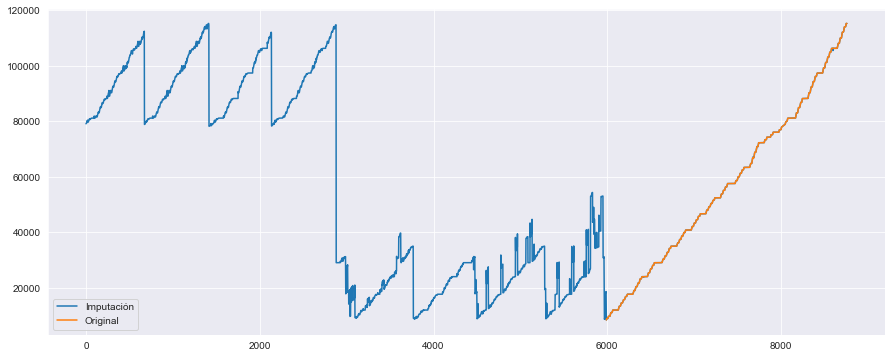

In [87]:
imputer=KNNImputer(n_neighbors=5, weights="uniform")
imputed_dataset = imputer.fit_transform(df.loc[2711].drop('SAMPLETIME',axis=1))

plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

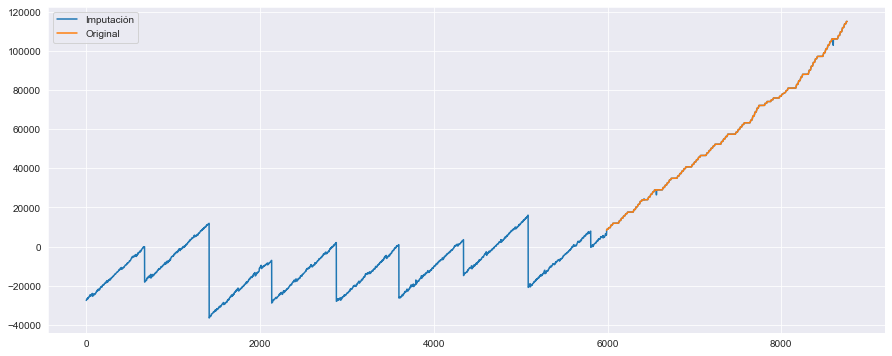

In [88]:
imputer=IterativeImputer(max_iter=10, random_state=42)
imputed_dataset = imputer.fit_transform(df.loc[2711].drop('SAMPLETIME',axis=1))

plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

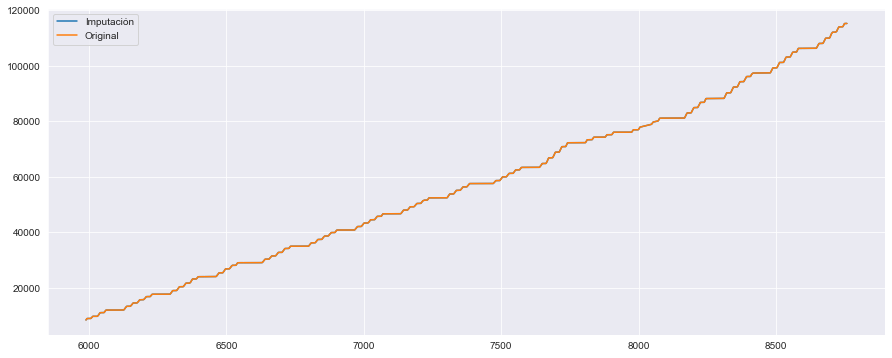

In [89]:
imputed_dataset = df.loc[2711].drop(['SAMPLETIME','YEAR','MONTH','DAY','HOUR','DAYWEEK','NACIONAL','AUTONOMICO','LOCAL'],axis=1).interpolate()

plt.plot(imputed_dataset["READINGINTEGER"].values, label = "Imputación")
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

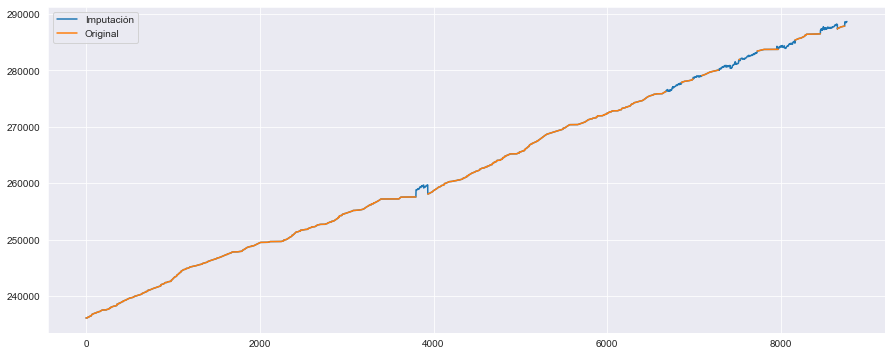

In [90]:
imputer=IterativeImputer(max_iter=10, random_state=42)
imputed_dataset = imputer.fit_transform(df.loc[1663].drop('SAMPLETIME',axis=1))

plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
plt.plot(df.loc[1663].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
plt.legend()
plt.show()

Parece que el .interpolate() de Pandas es el que mejor nos viene cuando los valores perdidos están en medio de la serie, y cuando no es así no nos queda otra que usar el IterativeImputer para extrapolar

11


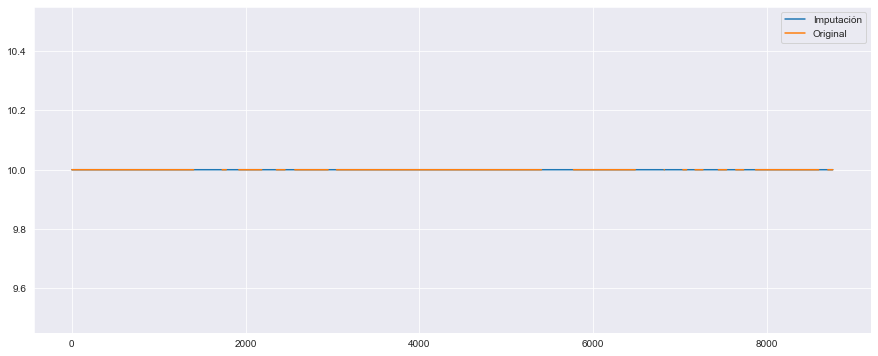

26


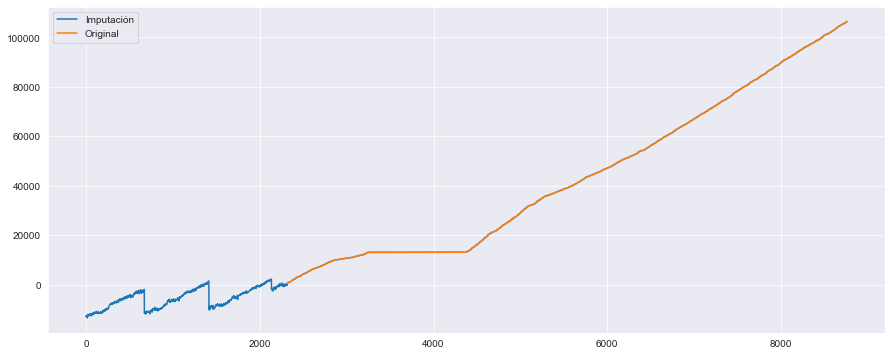

37


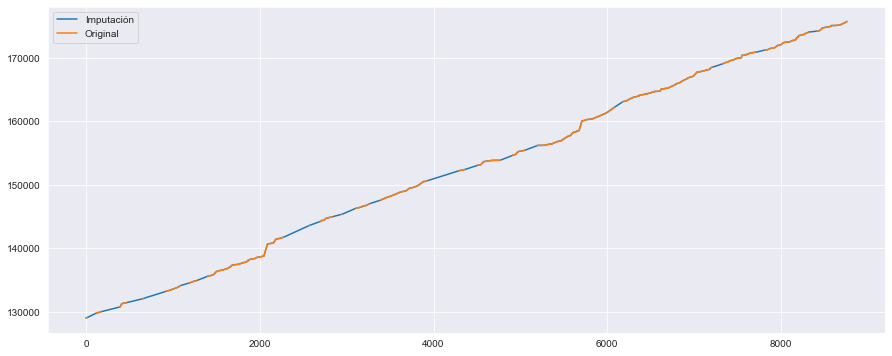

72


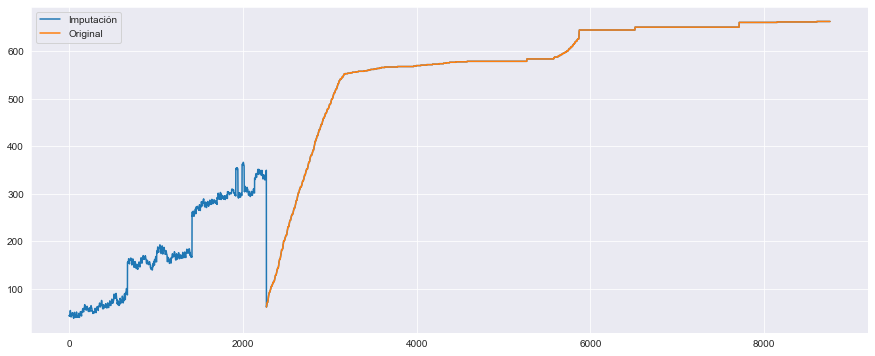

In [45]:
imputer=IterativeImputer(max_iter=10, random_state=42)

# Para cada índice
for i in [11, 26, 37, 72]:#tqdm(list_i):
    print(i)
    df_temp = df.loc[i]
    
    imputed_dataset = df.loc[i].drop(['SAMPLETIME'],axis=1).interpolate()
    
    imputed_dataset = imputer.fit_transform(imputed_dataset)

    plt.plot(pd.DataFrame(imputed_dataset).iloc[:,0], label = "Imputación")
    plt.plot(df.loc[i].sort_values('SAMPLETIME')["READINGINTEGER"].values, label = "Original")
    plt.legend()
    plt.show()

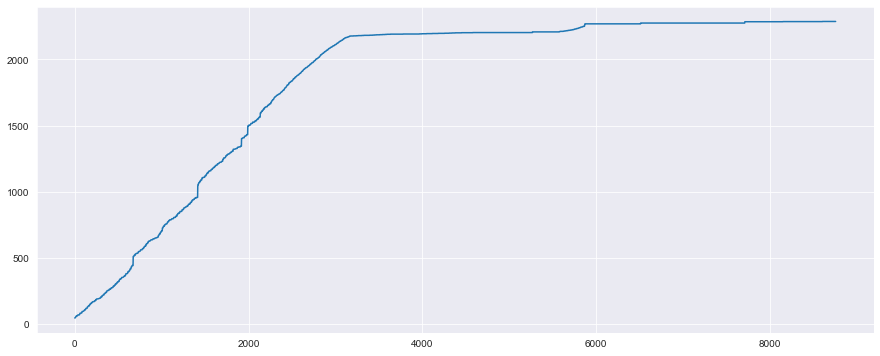

In [102]:
plt.plot(df.loc[72].sort_values('SAMPLETIME')["READINGINTEGER"].values)

A veces va bien, otras veces no. Lo mejor va a ser dejarlo así, porque no se me ocurre otra forma mejor, y después pasarle el código de limpieza.

In [49]:
df

,SAMPLETIME,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL
ID,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.0,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
0,2019-02-01 01:00:00,331710.0,2019.0,2.0,1.0,1.0,5.0,0.0,0.0,0.0,0.139474,0.565217,0.000945,0.0,0.431072,0.000000,0.117444
0,2019-02-01 02:00:00,331710.0,2019.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,0.136842,0.532609,0.000945,0.0,0.431072,0.000000,0.117444
0,2019-02-01 03:00:00,331710.0,2019.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.123684,0.554348,0.000945,0.0,0.431072,0.000000,0.117444
0,2019-02-01 04:00:00,331710.0,2019.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,0.160526,0.434783,0.000945,0.0,0.431072,0.000000,0.117444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,2020-01-31 19:00:00,NaN,2020.0,1.0,31.0,19.0,5.0,0.0,0.0,0.0,0.346579,0.479348,0.000945,0.0,0.376368,0.091828,0.000000
2756,2020-01-31 20:00:00,NaN,2020.0,1.0,31.0,20.0,5.0,0.0,0.0,0.0,0.329737,0.482609,0.000945,0.0,0.376368,0.091828,0.000000
2756,2020-01-31 21:00:00,NaN,2020.0,1.0,31.0,21.0,5.0,0.0,0.0,0.0,0.315000,0.502174,0.000945,0.0,0.376368,0.091828,0.000000


In [50]:
imputer=IterativeImputer(max_iter=10, random_state=42)

# Para cada índice
for i in tqdm(list_i):
    df_temp = df.loc[i]
    
    imputed_dataset = df.loc[i].drop(['SAMPLETIME'],axis=1).interpolate()
    
    imputed_dataset = imputer.fit_transform(imputed_dataset)
    
    df.loc[i, 'READINGINTEGER'] = pd.DataFrame(imputed_dataset).iloc[:,0].values

100%|██████████| 775/775 [03:00<00:00,  4.29it/s]


#### Correción de valores decrecientes

In [51]:
# Para cada contador (índice)
for i in tqdm(list_i):
    df_temp = df.loc[i]
        
    # Comprobamos uno por uno todos los valores comparándolos con el anterior
    for j in range(1,len(df_temp)):
        if df_temp.iloc[j]["READINGINTEGER"] < df_temp.iloc[j-1]["READINGINTEGER"]:
            
            new = df_temp.iloc[j-1]["READINGINTEGER"] - df_temp.iloc[j]["READINGINTEGER"]
            
            df.loc[i].loc[df_temp['SAMPLETIME'] >= df_temp.iloc[j]["SAMPLETIME"],'READINGINTEGER'] = df_temp.loc[df_temp['SAMPLETIME'] >= df_temp.iloc[j]["SAMPLETIME"],'READINGINTEGER'] + new

  0%|          | 1/775 [00:01<18:50,  1.46s/it]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 775/775 [28:08<00:00,  2.18s/it]


#### Detección de saltos

In [52]:
# Quitar warning de: A value is trying to be set on a copy of a slice from a DataFrame.
pd.set_option('mode.chained_assignment', None)

plt.rcParams["figure.figsize"] = (15,8)

MENOS_FILTRO = [1136]

# Para cada contador (índice)
for i in tqdm(list_i):
    df_temp = df.loc[i]
            
    df_temp['DELTA_I'] = df_temp.diff()['READINGINTEGER']
    df_temp['DELTA_H'] = df_temp.diff()['SAMPLETIME']
            
    diff = df_temp.READINGINTEGER.max() - df_temp.READINGINTEGER.min()

    maxDelta = diff / 200  # Unos 200 para 8759 valores
        
    if i in MENOS_FILTRO:
        maxDelta = maxDelta * 2
            
    # Filtramos si cambia de una hora para otra más de lo que "debería"
    df_temp_2 = df_temp.loc[(df_temp['DELTA_I'] > maxDelta) & (df_temp['DELTA_H'] == '0 days 01:00:00')]
            
    if (df_temp_2.count()["SAMPLETIME"] != 0) and (maxDelta > 200):
        #print(i, df_temp_2.count()["SAMPLETIME"])
                        
        #fig, axs = plt.subplots(2)
        #axs[0].plot(df.loc[i].sort_values('SAMPLETIME')["READINGINTEGER"].values)
                        
        for j in range(0,len(df_temp_2)):
            filtro = df_temp['SAMPLETIME'] >= df_temp_2.iloc[j]["SAMPLETIME"]

            # A todos los valores posteriores al salto, les restamos la diferencia de READINGINTEGER entre j y j-1 (que siempre > 0)
            df_temp.loc[filtro,'READINGINTEGER'] = df_temp.loc[filtro,'READINGINTEGER'] - df_temp_2.iloc[j]["DELTA_I"]
                            
        df.loc[i] = df_temp
                            
        #axs[1].plot(df_temp.sort_values('SAMPLETIME')["READINGINTEGER"].values)
        #plt.show()

plt.rcParams["figure.figsize"] = (15,6)

100%|██████████| 775/775 [08:00<00:00,  1.61it/s]


#### Creamos la variable DELTA definitiva

In [53]:
for i in tqdm(df.index.drop_duplicates()):
    df.loc[i, 'DELTA'] = df.loc[i].diff()['READINGINTEGER']

100%|██████████| 2747/2747 [04:47<00:00,  9.56it/s]


Los primeros valores se nos quedan con delta NaN, los reemplazamos por 0

In [54]:
df['DELTA'] = df['DELTA'].fillna(0)

In [55]:
df

,SAMPLETIME,READINGINTEGER,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,DELTA
ID,,,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,331710.000000,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444,0.0
0,2019-02-01 01:00:00,331710.000000,2019.0,2.0,1.0,1.0,5.0,0.0,0.0,0.0,0.139474,0.565217,0.000945,0.0,0.431072,0.000000,0.117444,0.0
0,2019-02-01 02:00:00,331710.000000,2019.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,0.136842,0.532609,0.000945,0.0,0.431072,0.000000,0.117444,0.0
0,2019-02-01 03:00:00,331710.000000,2019.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.123684,0.554348,0.000945,0.0,0.431072,0.000000,0.117444,0.0
0,2019-02-01 04:00:00,331710.000000,2019.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,0.160526,0.434783,0.000945,0.0,0.431072,0.000000,0.117444,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,2020-01-31 19:00:00,349782.885018,2020.0,1.0,31.0,19.0,5.0,0.0,0.0,0.0,0.346579,0.479348,0.000945,0.0,0.376368,0.091828,0.000000,0.0
2756,2020-01-31 20:00:00,349782.885018,2020.0,1.0,31.0,20.0,5.0,0.0,0.0,0.0,0.329737,0.482609,0.000945,0.0,0.376368,0.091828,0.000000,0.0
2756,2020-01-31 21:00:00,349782.885018,2020.0,1.0,31.0,21.0,5.0,0.0,0.0,0.0,0.315000,0.502174,0.000945,0.0,0.376368,0.091828,0.000000,0.0


In [ ]:
df.loc[df['DELTA'] < 0, 'DELTA'] = 0

Y guardamos el DataFrame final

In [56]:
df.to_csv('data/Modelar_UH2022_DEF.csv')

## Crear DataFrame de test

In [4]:
df = pd.read_csv('data/Modelar_Procesado_conNaN.csv', index_col='ID')
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)
df = df.sort_values(["ID", 'SAMPLETIME'])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
dic = {'ID': [], 'SAMPLETIME': []}

for id in df.index.drop_duplicates():
    for dia in range(1,15):
        for hora in range(24):
            fecha = "2019-02-" + str(dia) + " " + str(hora) + ":00:00"
            dic['ID'].append(id)
            dic['SAMPLETIME'].append(fecha)
            
df_test = pd.DataFrame(dic)

df_test['SAMPLETIME'] = pd.to_datetime(df_test.SAMPLETIME)
df_test = df_test.astype({"ID": int})
df_test = df_test.set_index("ID")
df_test = df_test.sort_values(["ID", 'SAMPLETIME'])

In [6]:
df_test

,SAMPLETIME
ID,
0,2019-02-01 00:00:00
0,2019-02-01 01:00:00
0,2019-02-01 02:00:00
0,2019-02-01 03:00:00
0,2019-02-01 04:00:00
...,...
2756,2019-02-14 19:00:00
2756,2019-02-14 20:00:00
2756,2019-02-14 21:00:00


In [7]:
df_test.to_csv('data/Predecir.csv')

Tenemos que añadirle las columnas que también añadimos al del entrenamiento

In [8]:
df_test['YEAR'] = df_test['SAMPLETIME'].dt.strftime('%Y').astype(int)
df_test['MONTH'] = df_test['SAMPLETIME'].dt.strftime('%m').astype(int)
df_test['DAY'] = df_test['SAMPLETIME'].dt.strftime('%e').astype(int)
df_test['HOUR'] = df_test['SAMPLETIME'].dt.strftime('%H').astype(int)
df_test['DAYWEEK'] = df_test['SAMPLETIME'].dt.strftime('%u').astype(int)

In [9]:
#FESTIVIDAD NACIONAL
anos = [2019,2020]

count_n = [[1,1,1,1,1,1,2],[2,1,1,1,1,2]]
meses_n = [[1,4,5,8,10,11,12],[1,4,5,8,10,12]]
nacionales = [[1,19,1,15,12,1,6,25],[1,6,10,1,15,12,8,25]]

count_a = [[2,1,1],[1,2,1,1]]
meses_a = [[4,6,10],[3,4,6,10]]
autonomicos = [[22,25,24,9],[19,13,25,24,9]]

count_l = [[1],[1]]
meses_l = [[1],[1]]
locales = [[22],[22]]

df_test['NACIONAL'] = 0
df_test['AUTONOMICO'] = 0
df_test['LOCAL'] = 0

nombres = ["NACIONAL", "AUTONOMICO", "LOCAL"]
aux_c = [count_n, count_a, count_l]
aux_m = [meses_n, meses_a, meses_l]
aux_d = [nacionales, autonomicos, locales]

for colum in nombres:
    meses = aux_m.pop(0)
    count = aux_c.pop(0)
    days = aux_d.pop(0)
    for ano in anos:
        meses2 = meses.pop(0)
        count2 = count.pop(0)
        days2 = days.pop(0)
        for m in meses2:
            cuenta = count2.pop(0)
            for d in range(0, cuenta): 
                df_test.loc[(df_test["YEAR"]==ano) & (df_test["MONTH"]==m) & (df_test["DAY"]==days2.pop(0)), colum] = 1
df_test


,SAMPLETIME,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL
ID,,,,,,,,,
0,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0
0,2019-02-01 01:00:00,2019,2,1,1,5,0,0,0
0,2019-02-01 02:00:00,2019,2,1,2,5,0,0,0
0,2019-02-01 03:00:00,2019,2,1,3,5,0,0,0
0,2019-02-01 04:00:00,2019,2,1,4,5,0,0,0
...,...,...,...,...,...,...,...,...,...
2756,2019-02-14 19:00:00,2019,2,14,19,4,0,0,0
2756,2019-02-14 20:00:00,2019,2,14,20,4,0,0,0
2756,2019-02-14 21:00:00,2019,2,14,21,4,0,0,0


In [10]:
df2 = pd.read_csv('data/PrecHumTempValencia.csv', sep='\;', encoding='ISO-8859-1')
df2 = df2.replace('"','', regex=True)
df2 = df2.replace(',','.', regex=True)
df2 = df2.rename(columns={"\"Fecha Hora": "Fecha", "Precip\"": "Precip"})
df2["Temp"] = pd.to_numeric(df2["Temp"])
df2["H.Rel"] = pd.to_numeric(df2["H.Rel"])
df2["R.Sol"] = pd.to_numeric(df2["R.Sol"])
df2["Precip"] = pd.to_numeric(df2["Precip"])
df2['Fecha'] = pd.to_datetime(df2.Fecha)
df2 = df2.set_index("Fecha")
df2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Estación,Temp,H.Rel,R.Sol,Precip
Fecha,,,,,
2020-01-01 00:00:00,Avda. Francia,6.6,890.0,0.0,0.0
2020-01-01 01:00:00,Avda. Francia,6.2,890.0,0.0,0.0
2020-01-01 02:00:00,Avda. Francia,5.9,900.0,0.0,0.0
2020-01-01 03:00:00,Avda. Francia,5.5,900.0,0.0,0.0
2020-01-01 04:00:00,Avda. Francia,5.3,890.0,0.0,0.0
...,...,...,...,...,...
2018-12-23 01:00:00,Politécnico,11.5,760.0,20.0,0.0
2018-12-23 02:00:00,Politécnico,11.0,770.0,10.0,0.0
2018-12-23 03:00:00,Politécnico,10.9,770.0,10.0,0.0


In [11]:
df2 = df2.sort_index()
df_group = df2.groupby("Fecha").mean()
df_group

,Temp,H.Rel,R.Sol,Precip
Fecha,,,,
2018-01-01 00:00:00,14.20,380.0,0.0,0.0
2018-01-01 01:00:00,12.80,460.0,0.0,0.0
2018-01-01 02:00:00,12.10,460.0,0.0,0.0
2018-01-01 03:00:00,11.20,450.0,0.0,0.0
2018-01-01 04:00:00,10.60,460.0,0.0,0.0
...,...,...,...,...
2020-12-31 19:00:00,11.15,442.0,4.0,0.0
2020-12-31 20:00:00,10.51,474.0,14.0,0.0
2020-12-31 21:00:00,10.37,506.0,4.0,0.0


In [12]:
imp = SimpleImputer(missing_values=np.nan)
idf = pd.DataFrame(imp.fit_transform(df_group))
idf.columns = df_group.columns
idf.index = df_group.index
idf

,Temp,H.Rel,R.Sol,Precip
Fecha,,,,
2018-01-01 00:00:00,14.20,380.0,0.0,0.0
2018-01-01 01:00:00,12.80,460.0,0.0,0.0
2018-01-01 02:00:00,12.10,460.0,0.0,0.0
2018-01-01 03:00:00,11.20,450.0,0.0,0.0
2018-01-01 04:00:00,10.60,460.0,0.0,0.0
...,...,...,...,...
2020-12-31 19:00:00,11.15,442.0,4.0,0.0
2020-12-31 20:00:00,10.51,474.0,14.0,0.0
2020-12-31 21:00:00,10.37,506.0,4.0,0.0


In [13]:
dfjoin = df_test.set_index('SAMPLETIME', append=True).reset_index(level=0)
dfjoin = dfjoin.join(idf)
dfjoin = dfjoin.set_index('ID', append=True).reset_index(level=0)
dfjoin = dfjoin.rename(columns={"level_0": "SAMPLETIME"})
dfjoin

,SAMPLETIME,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip
ID,,,,,,,,,,,,,
0,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0
1,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0
2,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0
3,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0
4,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0
2747,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0
2748,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0


In [14]:
dfjoin['FECHA'] = dfjoin['SAMPLETIME'].dt.strftime('%F')
dfjoin['FECHA'] = pd.to_datetime(dfjoin.FECHA)
precios_df = pd.read_excel('data\DATOS DIAS.xlsx')
precios_df = precios_df.astype({'FECHA': 'datetime64[ns]'})

precios_df = precios_df.set_index('FECHA')
df3 = dfjoin.set_index('FECHA', append=True).reset_index(level=0)
df3 = df3.join(precios_df)
df3 = df3.set_index('ID', append=True).reset_index(level=0)
dfjoin = df3.rename(columns={"level_0": "FECHA"})
dfjoin

,FECHA,SAMPLETIME,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,TARIFA DIARIA COMPLETA,OCUPACIÓN DIARIA COMPLETA,TARIFA DIARIA COMPARTIDA,OCUPACIÓN DIARIA COMPARTIDA,TARIFA DIARIA PRIVADA,OCUPACIÓN DIARIA PRIVADA
ID,,,,,,,,,,,,,,,,,,,,
0,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
1,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
2,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
3,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
4,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,71.92,0.561,41.33,0.059,28.45,0.378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,2019-02-14,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0,65.42,0.545,41.33,0.059,26.76,0.388
2747,2019-02-14,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0,65.42,0.545,41.33,0.059,26.76,0.388
2748,2019-02-14,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0,65.42,0.545,41.33,0.059,26.76,0.388


In [15]:
dfjoin['FECHA2'] = dfjoin['SAMPLETIME'].dt.strftime('%Y-%m')
dfjoin['FECHA2'] = pd.to_datetime(dfjoin.FECHA2)
hoteles_df = pd.read_excel('data\VIAJEROS Y PERNOTACIONES DE HOTELES Y APARTAMENTOS.xlsx')
hoteles_df = hoteles_df.drop(hoteles_df.columns[[0,1,2,3,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25]], axis=1)

hoteles_df['AÑO'] = hoteles_df['AÑO'].astype(str)
hoteles_df['MES'] = hoteles_df['MES'].astype(str)
hoteles_df['FECHA2'] = hoteles_df['AÑO'] + "-" + hoteles_df['MES']
hoteles_df['FECHA2'] = pd.to_datetime(hoteles_df.FECHA2)
hoteles_df = hoteles_df.set_index('FECHA2')

df3 = dfjoin.set_index('FECHA2', append=True).reset_index(level=0)
df3 = df3.join(hoteles_df)
df3 = df3.set_index('ID', append=True).reset_index(level=0)
dfjoin = df3.rename(columns={"level_0": "FECHA2"})
dfjoin

,FECHA2,FECHA,SAMPLETIME,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,...,TARIFA DIARIA COMPLETA,OCUPACIÓN DIARIA COMPLETA,TARIFA DIARIA COMPARTIDA,OCUPACIÓN DIARIA COMPARTIDA,TARIFA DIARIA PRIVADA,OCUPACIÓN DIARIA PRIVADA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,MES,AÑO
ID,,,,,,,,,,,,,,,,,,,,,
0,2019-02-01,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
1,2019-02-01,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
2,2019-02-01,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
3,2019-02-01,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
4,2019-02-01,2019-02-01,2019-02-01 00:00:00,2019,2,1,0,5,0,0,...,71.92,0.561,41.33,0.059,28.45,0.378,311599,46.87,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,2019-02-01,2019-02-14,2019-02-14 23:00:00,2019,2,14,23,4,0,0,...,65.42,0.545,41.33,0.059,26.76,0.388,311599,46.87,2,2019
2747,2019-02-01,2019-02-14,2019-02-14 23:00:00,2019,2,14,23,4,0,0,...,65.42,0.545,41.33,0.059,26.76,0.388,311599,46.87,2,2019
2748,2019-02-01,2019-02-14,2019-02-14 23:00:00,2019,2,14,23,4,0,0,...,65.42,0.545,41.33,0.059,26.76,0.388,311599,46.87,2,2019


In [16]:
dfjoin = dfjoin.drop(["FECHA2", "FECHA", "MES", "AÑO"], axis=1)

In [17]:
dfjoin = dfjoin.drop(["TARIFA DIARIA COMPLETA", "TARIFA DIARIA COMPARTIDA", "OCUPACIÓN DIARIA COMPARTIDA", "TARIFA DIARIA PRIVADA", "OCUPACIÓN DIARIA PRIVADA"], axis=1)

In [18]:
dfjoin

,SAMPLETIME,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL
ID,,,,,,,,,,,,,,,,
0,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,0.561,311599,46.87
1,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,0.561,311599,46.87
2,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,0.561,311599,46.87
3,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,0.561,311599,46.87
4,2019-02-01 00:00:00,2019,2,1,0,5,0,0,0,9.1,700.0,0.0,0.0,0.561,311599,46.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0,0.545,311599,46.87
2747,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0,0.545,311599,46.87
2748,2019-02-14 23:00:00,2019,2,14,23,4,0,0,0,9.3,780.0,10.0,0.0,0.545,311599,46.87


In [19]:
dfjoin.to_csv('data/Predecir_DEF.csv')

## Predicción

### XGBoost

In [20]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [21]:
df_test = pd.read_csv('data/Predecir_DEF.csv')
df_test = df_test.drop(['SAMPLETIME'],axis=1)
scaler = MinMaxScaler()
df_test[['Temp', 'H.Rel', 'R.Sol', 'Precip', 'OCUPACIÓN DIARIA COMPLETA', 'PERNOTACIONES TOTAL', 'OCUPACIÓN TOTAL']] = scaler.fit_transform(df_test[['Temp', 'H.Rel', 'R.Sol', 'Precip', 'OCUPACIÓN DIARIA COMPLETA', 'PERNOTACIONES TOTAL', 'OCUPACIÓN TOTAL']])
df_test

,ID,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL
0,0,2019,2,1,0,5,0,0,0,0.072650,0.652174,0.00000,0.0,1.000000,0.0,0.0
1,1,2019,2,1,0,5,0,0,0,0.072650,0.652174,0.00000,0.0,1.000000,0.0,0.0
2,2,2019,2,1,0,5,0,0,0,0.072650,0.652174,0.00000,0.0,1.000000,0.0,0.0
3,3,2019,2,1,0,5,0,0,0,0.072650,0.652174,0.00000,0.0,1.000000,0.0,0.0
4,4,2019,2,1,0,5,0,0,0,0.072650,0.652174,0.00000,0.0,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922987,2746,2019,2,14,23,4,0,0,0,0.081197,0.768116,0.00097,0.0,0.874016,0.0,0.0
922988,2747,2019,2,14,23,4,0,0,0,0.081197,0.768116,0.00097,0.0,0.874016,0.0,0.0
922989,2748,2019,2,14,23,4,0,0,0,0.081197,0.768116,0.00097,0.0,0.874016,0.0,0.0
922990,2749,2019,2,14,23,4,0,0,0,0.081197,0.768116,0.00097,0.0,0.874016,0.0,0.0


In [22]:
df = pd.read_csv('data/Modelar_UH2022_DEF.csv', index_col='ID', parse_dates=True)
df = df.drop(['SAMPLETIME','READINGINTEGER'],axis=1)
df = df.reset_index(drop=False)
df

,ID,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,DELTA
0,0,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444,0.0
1,0,2019.0,2.0,1.0,1.0,5.0,0.0,0.0,0.0,0.139474,0.565217,0.000945,0.0,0.431072,0.000000,0.117444,0.0
2,0,2019.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,0.136842,0.532609,0.000945,0.0,0.431072,0.000000,0.117444,0.0
3,0,2019.0,2.0,1.0,3.0,5.0,0.0,0.0,0.0,0.123684,0.554348,0.000945,0.0,0.431072,0.000000,0.117444,0.0
4,0,2019.0,2.0,1.0,4.0,5.0,0.0,0.0,0.0,0.160526,0.434783,0.000945,0.0,0.431072,0.000000,0.117444,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24060968,2756,2020.0,1.0,31.0,19.0,5.0,0.0,0.0,0.0,0.346579,0.479348,0.000945,0.0,0.376368,0.091828,0.000000,0.0
24060969,2756,2020.0,1.0,31.0,20.0,5.0,0.0,0.0,0.0,0.329737,0.482609,0.000945,0.0,0.376368,0.091828,0.000000,0.0
24060970,2756,2020.0,1.0,31.0,21.0,5.0,0.0,0.0,0.0,0.315000,0.502174,0.000945,0.0,0.376368,0.091828,0.000000,0.0
24060971,2756,2020.0,1.0,31.0,22.0,5.0,0.0,0.0,0.0,0.306053,0.516304,0.000945,0.0,0.376368,0.091828,0.000000,0.0


In [23]:
df = df.sort_values(by=['YEAR', 'MONTH', 'DAY', 'HOUR'])
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [24]:
X

,ID,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL
0,0,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
8759,1,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
17518,2,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
26277,3,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
35036,4,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24025936,2746,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000
24034695,2747,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000
24043454,2748,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000
24052213,2749,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000


In [25]:
y

0           0.0
8759        0.0
17518       0.0
26277       0.0
35036       0.0
           ... 
24025936    0.0
24034695    0.0
24043454    0.0
24052213    0.0
24060972    0.0
Name: DELTA, Length: 24060973, dtype: float64

Dividimos en train y test para probar (teniendo en cuenta que hay 23982142 filas)

In [7]:
test_size = int(23982142 * 0.2)

X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [6]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)

In [9]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [10]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 129.863155


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

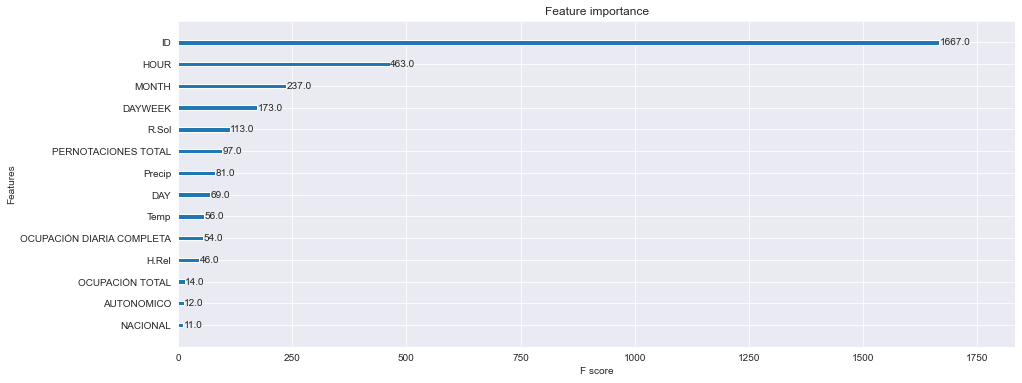

In [12]:
xgb.plot_importance(xg_reg)

#### Predecir una vez para cada ID

In [7]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)

errores = []

for i in tqdm(df['ID'].drop_duplicates()):
    filtro = df['ID'] == i
    
    X, y = df[filtro].iloc[:,:-1], df[filtro].iloc[:,-1]
    
    test_size = int(len(X.index) * 0.2)

    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    
    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)
    
    errores.append(np.sqrt(mean_squared_error(y_test, preds)))

100%|██████████| 2738/2738 [14:56<00:00,  3.05it/s]


In [9]:
nperr = np.array(errores)

In [12]:
rmse = np.sqrt(np.mean(np.square(nperr)))
print("RMSE: %f" % (rmse))

RMSE: 152.351626


### Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
my_rf = RandomForestRegressor()
my_rf.fit(X_train, y_train)
 
# predict on the same period
preds = my_rf.predict(X_test)
 
# plot what has been learned
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
my_rf.feature_importances_

## Imprimir resultados formato UniversityHack

Primero vamos a entrenar un XGBoost

In [26]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)
X, y = df.iloc[:,:-1], df.iloc[:,-1]
xg_reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [27]:
X

,ID,YEAR,MONTH,DAY,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL
0,0,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
8759,1,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
17518,2,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
26277,3,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
35036,4,2019.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0,0.144737,0.597826,0.000945,0.0,0.431072,0.000000,0.117444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24025936,2746,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000
24034695,2747,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000
24043454,2748,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000
24052213,2749,2020.0,1.0,31.0,23.0,5.0,0.0,0.0,0.0,0.297105,0.507609,0.000945,0.0,0.376368,0.091828,0.000000


In [28]:
preds = xg_reg.predict(df_test)
preds

array([20.01213  , 20.01213  , 20.01213  , ...,  2.0438747,  2.0438747,
       -2.7841046], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

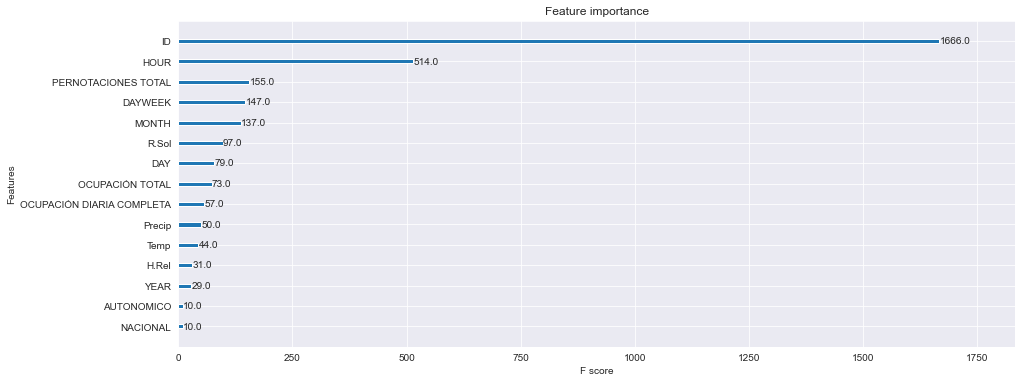

In [29]:
xgb.plot_importance(xg_reg)

Y pasamos las predicciones al Cajamar_Universidad de Castilla La Mancha (UCLM)_DPNA_numeral.txt

In [30]:
df_test_day = df_test.set_index(['ID'])
df_test_day['PRED'] = preds
df_test_day = df_test_day.groupby(['DAY','ID']).mean()
df_test_day

YEAR  MONTH  HOUR  DAYWEEK  NACIONAL  AUTONOMICO  LOCAL      Temp  \
DAY ID                                                                          
1   0     2019.0    2.0  11.5      5.0       0.0         0.0    0.0  0.203882   
    1     2019.0    2.0  11.5      5.0       0.0         0.0    0.0  0.203882   
    2     2019.0    2.0  11.5      5.0       0.0         0.0    0.0  0.203882   
    3     2019.0    2.0  11.5      5.0       0.0         0.0    0.0  0.203882   
    4     2019.0    2.0  11.5      5.0       0.0         0.0    0.0  0.203882   
...          ...    ...   ...      ...       ...         ...    ...       ...   
14  2746  2019.0    2.0  11.5      4.0       0.0         0.0    0.0  0.208868   
    2747  2019.0    2.0  11.5      4.0       0.0         0.0    0.0  0.208868   
    2748  2019.0    2.0  11.5      4.0       0.0         0.0    0.0  0.208868   
    2749  2019.0    2.0  11.5      4.0       0.0         0.0    0.0  0.208868   
    2756  2019.0    2.0  11.5      4.0       0.0         0.0    0.0  0.208868   

             H.Rel     R.Sol  Precip  OCUPACIÓN DIARIA COMPLETA  \
DAY ID                                                            
1   0     0.455918  0.128193     0.0                   1.000000   
    1     0.455918  0.128193     0.0                   1.000000   
    2     0.455918  0.128193     0.0                   1.000000   
    3     0.455918  0.128193     0.0                   1.000000   
    4     0.455918  0.128193     0.0                   1.000000   
...            ...       ...     ...                        ...   
14  2746  0.604469  0.111946     0.0                   0.874016   
    2747  0.604469  0.111946     0.0                   0.874016   
    2748  0.604469  0.111946     0.0                   0.874016   
    2749  0.604469  0.111946     0.0                   0.874016   
    2756  0.604469  0.111946     0.0                   0.874016   

          PERNOTACIONES TOTAL  OCUPACIÓN TOTAL       PRED  
DAY ID                                                     
1   0                     0.0              0.0  17.254486  
    1                     0.0              0.0  17.254486  
    2                     0.0              0.0  17.254486  
    3                     0.0              0.0  17.254486  
    4                     0.0              0.0  17.254486  
...                       ...              ...        ...  
14  2746                  0.0              0.0   5.809919  
    2747                  0.0              0.0   5.809919  
    2748                  0.0              0.0   5.809919  
    2749                  0.0              0.0   5.809919  
    2756                  0.0              0.0   0.293935  

[38458 rows x 15 columns]

In [31]:
df['ID'].drop_duplicates()

0              0
8759           1
17518          2
26277          3
35036          4
            ... 
24017178    2746
24025937    2747
24034696    2748
24043455    2749
24052214    2756
Name: ID, Length: 2747, dtype: int64

In [32]:
df_test_day.loc[2]

,YEAR,MONTH,HOUR,DAYWEEK,NACIONAL,AUTONOMICO,LOCAL,Temp,H.Rel,R.Sol,Precip,OCUPACIÓN DIARIA COMPLETA,PERNOTACIONES TOTAL,OCUPACIÓN TOTAL,PRED
ID,,,,,,,,,,,,,,,
0,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,11.850523
1,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,11.850523
2,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,11.850523
3,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,11.850523
4,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,11.850523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,5.716958
2747,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,5.716958
2748,2019.0,2.0,11.5,6.0,0.0,0.0,0.0,0.194266,0.202295,0.135427,0.008333,0.826772,0.0,0.0,5.716958


In [33]:
nuevodf = pd.DataFrame()

In [34]:
for i in range (1,8):
    nuevodf[str(i)] = df_test_day.loc[i, 'PRED']
    
nuevodf

,1,2,3,4,5,6,7
ID,,,,,,,
0,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930
1,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930
2,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930
3,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930
4,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930
...,...,...,...,...,...,...,...
2746,7.911370,5.716958,5.807267,6.960413,5.761512,6.827106,6.952509
2747,7.911370,5.716958,5.807267,6.960413,5.761512,6.827106,6.952509
2748,7.911370,5.716958,5.807267,6.960413,5.761512,6.827106,6.952509


In [35]:
nuevodf["sem1"] = nuevodf["1"] + nuevodf["2"] + nuevodf["3"] + nuevodf["4"] + nuevodf["5"] + nuevodf["6"] + nuevodf["7"]

nuevodf["sem2"] = df_test_day.loc[8, 'PRED'] + df_test_day.loc[9, 'PRED'] + df_test_day.loc[10, 'PRED'] + df_test_day.loc[11, 'PRED'] + df_test_day.loc[12, 'PRED'] + df_test_day.loc[13, 'PRED'] + df_test_day.loc[14, 'PRED']
nuevodf

,1,2,3,4,5,6,7,sem1,sem2
ID,,,,,,,,,
0,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930,113.767197,113.800735
1,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930,113.767197,113.800735
2,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930,113.767197,113.800735
3,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930,113.767197,113.800735
4,17.254486,11.850523,12.130639,17.390978,17.549852,18.453787,19.136930,113.767197,113.800735
...,...,...,...,...,...,...,...,...,...
2746,7.911370,5.716958,5.807267,6.960413,5.761512,6.827106,6.952509,45.937138,47.904427
2747,7.911370,5.716958,5.807267,6.960413,5.761512,6.827106,6.952509,45.937138,47.904427
2748,7.911370,5.716958,5.807267,6.960413,5.761512,6.827106,6.952509,45.937138,47.904427


In [36]:
nuevodf.to_csv('salida/Cajamar_Universidad de Castilla La Mancha (UCLM)_DPNA_1.txt', sep='|', float_format='%.2f', header=False)

In [37]:
nuevodf["1"] = 0
nuevodf["2"] = 0
nuevodf["3"] = 0
nuevodf["4"] = 0
nuevodf["5"] = 0
nuevodf["6"] = 0
nuevodf["7"] = 0
nuevodf["sem1"] = 0
nuevodf["sem2"] = 0

In [38]:
nuevodf.to_csv('salida/Cajamar_Universidad de Castilla La Mancha (UCLM)_DPNA_2.txt', sep='|', float_format='%.2f', header=False)

In [39]:
nuevodf

,1,2,3,4,5,6,7,sem1,sem2
ID,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2746,0,0,0,0,0,0,0,0,0
2747,0,0,0,0,0,0,0,0,0
2748,0,0,0,0,0,0,0,0,0
